In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer as Tokenizer_keras
import tensorflow_hub as hub


import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

/home/rasoluci/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to /home/rasoluci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## data preparation

In [5]:
rawData = pd.read_csv("data/train.csv")
rawData['lowerCase']=rawData['text'].apply(str.lower)
target = rawData.target

In [6]:
rawData

,id,keyword,location,text,target,lowerCase
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @thetawniest the out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e-bike collided ...


In [7]:
df_train, df_dev, y_train, y_dev = train_test_split(rawData, target, test_size=0.33)

y_train = np.asarray(y_train).astype('float32')
y_dev = np.asarray(y_dev).astype('float32')

# Modelling

## Classic ML model

## Use of Pipeline

In [10]:
class TfIdfPreprocess(BaseEstimator, TransformerMixin):
    def __init__(self,columnName): # no *args or **kargs
        self.columnName = columnName
        
    def fit(self, X, y=None):
         return self # nothing else to do
        
    def transform(self, X, y=None):
        
        excludeAll = set(string.punctuation)
        englishStopwords = stopwords.words('english')
        snowball = SnowballStemmer(language = 'english')
        def stemAndRemoveStopW(text):
            return " ".join([snowball.stem(w) for w in word_tokenize(str(text)) if w not in englishStopwords]) 
        
        no_punct = X[self.columnName].apply(lambda text: "".join([c for c in text if c not in excludeAll]))
        stemmedNoStopWords = no_punct.apply(stemAndRemoveStopW)
        return stemmedNoStopWords

In [11]:
pipe = Pipeline([
    ('preprocess',TfIdfPreprocess('lowerCase')),
    ('tdfIdf',TfidfVectorizer()),
    ('linearModel',LogisticRegression(penalty='l1'))
])

In [39]:
string.punctuation+ " "

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

In [12]:
pipeModel = pipe.fit(df_train,y_train)

/home/rasoluci/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
pipeModel.score(df_dev,y_dev)

0.7699960206923995

## gridSearch

In [14]:
parameters = {'linearModel__C':[0.1, 0.5,1,5, 10, 100,1000]}
gsPipeModel = GridSearchCV(pipeModel, parameters)#, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)[source]¶

In [15]:
pipe['linearModel']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
gsPipeFittedModel = gsPipeModel.fit(df_train,y_train)

/home/rasoluci/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/rasoluci/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rasoluci/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rasoluci/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rasoluci/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432

In [26]:
gsPipeFittedModel.best_estimator_.predict()

TypeError: score() missing 1 required positional argument: 'X'

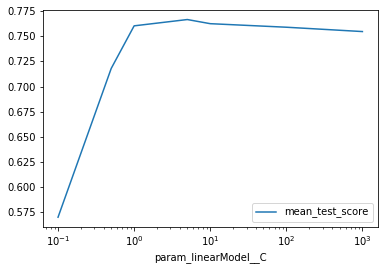

In [18]:
pd.DataFrame(gsPipeFittedModel.cv_results_).plot(x='param_linearModel__C',y='mean_test_score')
pd.DataFrame(gsPipeFittedModel.cv_results_).plot(x='param_linearModel__C',y='mean_test_score')
plt.xscale("log")

In [19]:
gsPipeFittedModel.best_estimator_.score(df_dev,y_dev)

0.7719856744926383

## Use Glove embedding

In [43]:
embeddings_dict = {}
with open("data/glove.twitter.27B.25d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [44]:
embeddings_dict['[']

array([ 0.033481 , -0.97308  , -0.067736 , -0.13024  ,  0.90959  ,
       -0.47889  ,  2.0581   ,  2.348    ,  0.64141  , -0.23736  ,
        0.63517  ,  1.0368   , -2.2095   ,  0.51406  , -1.0251   ,
       -1.5808   , -1.232    ,  0.57945  , -1.051    , -0.36801  ,
       -0.46394  , -1.8028   ,  0.10331  ,  0.0040312, -0.28344  ],
      dtype=float32)

In [120]:
no_punct = rawData['lowerCase'].apply(lambda text: "".join([c for c in text if c not in set(string.punctuation)]))


In [121]:
tok = no_punct.apply(lambda text: word_tokenize(text))

In [122]:
tokz

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [13000, people, receive, wildfires, evacuation...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [ariaahrary, thetawniest, the, out, of, contro...
7610    [m194, 0104, utc5km, s, of, volcano, hawaii, h...
7611    [police, investigating, after, an, ebike, coll...
7612    [the, latest, more, homes, razed, by, northern...
Name: lowerCase, Length: 7613, dtype: object

In [115]:
b

[2, 3, 4]

In [138]:
def try_embed(word):
    try: emb = embeddings_dict[word].T
    except:
        None
    return emb 

In [158]:
emb = tok.apply(lambda text: [try_embed(word) for word in text]) 

In [141]:
emb

0       [[-0.42047, 0.56526, -0.033577, 0.31019, 0.189...
1       [[-1.2358, -0.58127, 0.20145, 0.01657, -1.3504...
2       [[-0.18232, 0.96997, 0.32174, -0.074793, -0.11...
3       [None, [0.61531, 0.40895, -0.34224, 0.21094, -...
4       [[-0.35518, 0.4803, 0.49681, -0.76379, -0.6458...
                              ...                        
7608    [[0.58296, 0.44517, 1.0406, -0.047745, 0.01511...
7609    [None, None, [-0.010167, 0.020194, 0.21473, 0....
7610    [None, None, None, [0.71211, -0.18827, -0.836,...
7611    [[0.30003, 0.34859, -0.2896, -0.30224, -0.5052...
7612    [[-0.010167, 0.020194, 0.21473, 0.17289, -0.43...
Name: lowerCase, Length: 7613, dtype: object

# TF

In [37]:
TfIdfPreprocess('lowerCase').transform(df_dev)

1296                                  star burn voic mind
1527    emerg respons hazard chemic manag principl pra...
2230    schelbertgeorg thank im teach onlin class amp ...
5718    video pick bodi water rescuer search hundr mig...
6630                                officialmqm terrorist
                              ...                        
233     offici skip fantasticfourfant4sticwhatev hasht...
3088    omarmolina036 milioooo hes tri electrocut ya a...
466     volleybal attack ii volleybal train machin set...
4292    prophet peac upon said save hellfir even give ...
4136    calgari transit review polici leav hundr commu...
Name: lowerCase, Length: 2513, dtype: object

In [42]:
df_train

,id,keyword,location,text,target,lowerCase
3773,5356,fire,University of South Florida,It may seem like our fire has been a little bu...,0,it may seem like our fire has been a little bu...
4649,6610,inundated,NYC&NJ,@allyinwondrland That sounds like the perfect ...,0,@allyinwondrland that sounds like the perfect ...
2175,3118,debris,NaN,#?? #???? #??? #??? MH370: Aircraft debris fou...,1,#?? #???? #??? #??? mh370: aircraft debris fou...
2526,3629,desolation,"Kalimantan Timur, Indonesia",'cause right now I can read too good don't sen...,0,'cause right now i can read too good don't sen...
6459,9240,suicide%20bombing,NaN,1 of the major reason of suicide bombing is th...,1,1 of the major reason of suicide bombing is th...
...,...,...,...,...,...,...
1037,1503,body%20bags,NaN,@ScottWalker So you can send the poor and midd...,0,@scottwalker so you can send the poor and midd...
1528,2210,chemical%20emergency,"Littleton, CO, USA",THE CHEMICAL BROTHERS to play The Armory in SF...,0,the chemical brothers to play the armory in sf...
6375,9110,suicide%20bomb,Email: Lovethterry@gmail.com,See the 16yr old PKK suicide bomber who detona...,1,see the 16yr old pkk suicide bomber who detona...
3273,4698,epicentre,London/Surrey,@carneross indeed and a remarkably puny idea t...,0,@carneross indeed and a remarkably puny idea t...


In [27]:
# find tweet given word
word = "decisionsondecis"
completeTweets = rawData[rawData.noPunctAll.apply(lambda text: True if word in text else False)]
completeTweetEx = completeTweets.iloc[0]
completeTweetEx

AttributeError: 'DataFrame' object has no attribute 'noPunctAll'

In [29]:
rawData['noPunctAll']=  rawData[rawData.noPunctAll.apply(lambda text: True if word in text else False)].iloc[1]['noPunctAll']


AttributeError: 'DataFrame' object has no attribute 'noPunctAll'

In [30]:
rawData['noPunctAll']

,id,keyword,location,text,target,lowerCase
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @thetawniest the out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e-bike collided ...


_______

# KERAS

## Logistic Model

In [81]:
tfIdfLogisticModel = tf.keras.Sequential()
#logisticModel.add(tf.keras.layers.DenseFeatures())
#logisticModel.add(tf.keras.layers.Dense(vocabSize,activation='linear'))
tfIdfLogisticModel.add(tf.keras.layers.Dense(1,activation='sigmoid',use_bias=True,kernel_regularizer=None))#tf.keras.regularizers.l1(0.)))

In [82]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)
EmbeddedLogistic = None  # TODO

In [83]:
tfIdfLogisticModel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
history = tfIdfLogisticModel.fit(x=X_train.todense(),y=y_train,#.shuffle(10000).batch(512),
                    epochs=120,
                   validation_data=[X_validate.todense(),y_validate],#.batch(512),
                    verbose=1)

Train on 5100 samples, validate on 2513 samples
Epoch 1/120
5100/5100 [==============================] - 3s 557us/sample - loss: 0.7526 - accuracy: 0.5649 - val_loss: 0.7509 - val_accuracy: 0.5758
Epoch 2/120
5100/5100 [==============================] - 1s 132us/sample - loss: 0.7405 - accuracy: 0.5692 - val_loss: 0.7407 - val_accuracy: 0.5758
Epoch 3/120
5100/5100 [==============================] - 16s 3ms/sample - loss: 0.7294 - accuracy: 0.5706 - val_loss: 0.7319 - val_accuracy: 0.5802
Epoch 4/120
5100/5100 [==============================] - 1s 168us/sample - loss: 0.7198 - accuracy: 0.5724 - val_loss: 0.7242 - val_accuracy: 0.5810
Epoch 5/120
5100/5100 [==============================] - 1s 128us/sample - loss: 0.7115 - accuracy: 0.5737 - val_loss: 0.7177 - val_accuracy: 0.5814
Epoch 6/120
5100/5100 [==============================] - 1s 129us/sample - loss: 0.7045 - accuracy: 0.5745 - val_loss: 0.7123 - val_accuracy: 0.5830
Epoch 7/120
5100/5100 [==============================] - 1s

## RNN model

In [45]:
df_train.lowerCase

3773    it may seem like our fire has been a little bu...
4649    @allyinwondrland that sounds like the perfect ...
2175    #?? #???? #??? #??? mh370: aircraft debris fou...
2526    'cause right now i can read too good don't sen...
6459    1 of the major reason of suicide bombing is th...
                              ...                        
1037    @scottwalker so you can send the poor and midd...
1528    the chemical brothers to play the armory in sf...
6375    see the 16yr old pkk suicide bomber who detona...
3273    @carneross indeed and a remarkably puny idea t...
2129    silence. #palermo #shipwreck #children #deaths...
Name: lowerCase, Length: 5100, dtype: object

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.lowerCase,y_train))
dev_ds = tf.data.Dataset.from_tensor_slices((df_dev.lowerCase,y_dev))

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((rawData.lowerCase, rawData.target))

In [55]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)


In [56]:
train_examples_batch, train_labels_batch = next(iter(train_ds.batch(1)))

In [59]:
train_examples_batch[:1]

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'it may seem like our fire has been a little burnt out....'],
      dtype=object)>

In [57]:
hub_layer(train_examples_batch[:1])

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 1.2411782 , -0.84538037,  0.99337894,  0.9411869 , -1.4618151 ,
        -1.4166778 , -1.0091518 ,  1.1085716 ,  1.3682624 ,  0.3634255 ,
         0.03297828,  1.6687071 , -0.72201407, -0.2184849 , -1.6352917 ,
         1.2544073 ,  1.313856  , -0.73420215, -1.416537  , -0.46678862]],
      dtype=float32)>

In [6]:
next(iter(dataset.batch(10)))

(<tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'our deeds are the reason of this #earthquake may allah forgive us all',
        b'forest fire near la ronge sask. canada',
        b"all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected",
        b'13,000 people receive #wildfires evacuation orders in california ',
        b'just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school ',
        b'#rockyfire update => california hwy. 20 closed in both directions due to lake county fire - #cafire #wildfires',
        b'#flood #disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas',
        b"i'm on top of the hill and i can see a fire in the woods...",
        b"there's an emergency evacuation happening now in the building across the street",
        b"i'm afraid that the tornado is coming to our area..."],
       dtype=object)>,
 <tf.Tensor

In [ ]:
train_dataset =
test_dataset =

In [93]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [91]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

In [36]:
x = np.array(np.arange(100)/100)

In [123]:
x = Uniform distributed [0,1]
x_max = 0.1 # upper boundary
x_min  =0.01 # lower boundary
par = 5 # parameter, the larger, the more exploration of values close to zero
y= (x_max)*(np.exp(-(par*x))) OR  y= (x_max/(x_min+1))*(np.exp(-(par*x)))+x_min # la deuxieme si tu veux setter un lower boundary

In [132]:
y= (x_max)*(np.exp(-(par*x)))

In [133]:
x

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

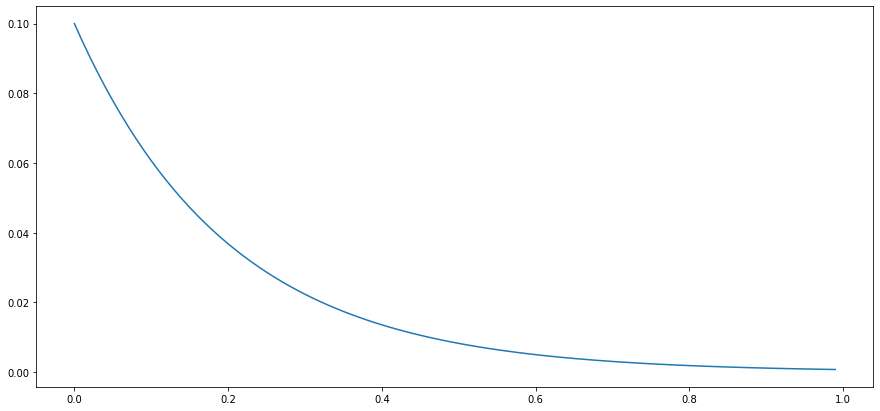

In [135]:
plt.plot(x,y)
#plt.yscale("log")